In [37]:
from prophet import Prophet
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
import seaborn as sns
# Disable Prophet logging info messages
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

In [38]:
basepath = '..\\data\\top_10_crimes'

In [39]:
districts = os.listdir(basepath)
crimes = os.listdir(os.path.join(basepath, districts[0]))

print(f"districts: {districts}")
print(f"crimes: {crimes}")

districts: ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']
crimes: ['Aggravated Assault', 'Assault', 'Auto Theft', 'Burglary', 'Domestic Assault', 'Domestic Violence', 'Property Damage', 'Sexual Assault', 'Shoplifting', 'Stolen Auto']


In [40]:
df = pd.read_csv(os.path.join(basepath, "1.0", "Aggravated Assault", "test.csv"))

In [41]:
#show the first 5 rows of the dataframe
print(df.head())

  Reported_Date  Crime_Count
0    2024-01-01           12
1    2024-01-02            2
2    2024-01-03            4
3    2024-01-04            0
4    2024-01-05            0


In [42]:
def plot_crime_forecast(train_data, test_data, forecast_data, path, crime_type="Unknown Crime", district_id="Unknown District", plot_train_aswell = False):
    plt.figure(figsize=(20, 6))

    if plot_train_aswell:
        # Plot training data
        plt.plot(train_data['ds'], train_data['y'], label="Training Data", color="blue")

    # Plot test data if it exists
    if len(test_data) > 0:
        plt.plot(test_data['ds'], test_data['y'], label="Test Data (Actual)", color="green")

    # Plot forecasted trend line
    plt.plot(forecast_data['ds'], forecast_data['trend'], label="Forecast Trend", color="purple")

    # Plot forecast data (mean predictions)
    plt.plot(forecast_data['ds'], forecast_data['yhat'], label="Predictions", color="red", linestyle="--")

    # Plot the uncertainty interval
    plt.fill_between(
        forecast_data['ds'], 
        forecast_data['yhat_lower'], 
        forecast_data['yhat_upper'], 
        color="pink", 
        alpha=0.3, 
        label="Prediction Interval"
    )

    # Formatting the plot
    plt.title(f"Crime Forecast for {crime_type} in District {district_id}")
    plt.xlabel("Date")
    plt.ylabel("Number of Crimes")
    plt.legend(loc="upper left")
    plt.grid(True)

    # Save the plot
    if os.path.exists(path):
        plt.savefig(os.path.join(path, "Prophet_forecast.png"))
    plt.close()


In [ ]:
rmse_dict = {}

for dist_id in tqdm.tqdm(districts, desc=f"Prophet Training and Prediction", leave=False):
    crimes = os.listdir(os.path.join(basepath, str(dist_id)))
    rmse_dict[str(dist_id)] = {}
    for crime in crimes:
        rmse_dict[str(dist_id)][crime] = {}

        # load data
        train = pd.read_csv(os.path.join(basepath, dist_id, crime, "train.csv"))
        test = pd.read_csv(os.path.join(basepath, dist_id, crime, "test.csv"))

        # Prepare data for Prophet
        train = train.reset_index().rename(columns={'Reported_Date': 'ds', 'Crime_Count': 'y'})
        test = test.reset_index().rename(columns={'Reported_Date': 'ds', 'Crime_Count': 'y'})

        # Ensure 'ds' is datetime
        train['ds'] = pd.to_datetime(train['ds'])
        test['ds'] = pd.to_datetime(test['ds'])

        if train.isna().values.any():
            print(f"NaN values in train for district {dist_id}, crime {crime}")

        # Fit Prophet model
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            seasonality_mode='multiplicative',
            changepoint_prior_scale=0.5,
            seasonality_prior_scale=10.0,
        )
        model.fit(train)

        forecast_data = test.copy()
        forecast_data.drop(columns=['y'])
        forecast = model.predict(forecast_data)
        
        rmse = root_mean_squared_error(test['y'], forecast['yhat'])
        rmse_dict[str(dist_id)][crime]["rmse"] = rmse

        # create a plot directory
        plot_directory = os.path.join("prophet_plots", str(dist_id), crime)
        os.makedirs(plot_directory, exist_ok=True)
        plot_crime_forecast(train, test, forecast, path=plot_directory, crime_type=crime, district_id=dist_id)

print(rmse_dict)

{'1.0': {'Aggravated Assault': {'rmse': 1.5621167110159542}, 'Assault': {'rmse': 1.8438853818705814}, 'Auto Theft': {'rmse': 1.4907540794819705}, 'Burglary': {'rmse': 1.189163054880841}, 'Domestic Assault': {'rmse': 0.9117583692032944}, 'Domestic Violence': {'rmse': 1.6760306734935895}, 'Property Damage': {'rmse': 1.3953208893453384}, 'Sexual Assault': {'rmse': 1.4842541549597152}, 'Shoplifting': {'rmse': 6.197057027323834}, 'Stolen Auto': {'rmse': 1.8414015232273946}}, '2.0': {'Aggravated Assault': {'rmse': 1.4387483619675228}, 'Assault': {'rmse': 1.87023674688081}, 'Auto Theft': {'rmse': 1.6279810843713172}, 'Burglary': {'rmse': 1.0265372057012347}, 'Domestic Assault': {'rmse': 1.0691564662500939}, 'Domestic Violence': {'rmse': 2.763759140860276}, 'Property Damage': {'rmse': 2.0945594743715814}, 'Sexual Assault': {'rmse': 2.090297206567633}, 'Shoplifting': {'rmse': 1.5578462936838882}, 'Stolen Auto': {'rmse': 2.8173977467804723}}, '3.0': {'Aggravated Assault': {'rmse': 7.873474485935

In [49]:
def plot_rmse_heatmap(crime_dist_dict):
    """
    Function to create a heatmap plot of RMSE values for crimes across districts
    """
    # Initialize an empty dictionary to hold RMSE values
    rmse_data = {
        "District": [],
        "Crime": [],
        "RMSE": []
    }
    
    # Collect RMSE values for each crime in each district
    for dist_id, crimes in crime_dist_dict.items():
        for crime_name, crime_info in crimes.items():
            if crime_info.get("rmse") is not None:
                rmse_data["District"].append(dist_id)
                rmse_data["Crime"].append(crime_name)
                rmse_data["RMSE"].append(crime_info["rmse"])
    
    # Create a DataFrame from the collected RMSE data
    rmse_df = pd.DataFrame(rmse_data)
    rmse_pivot = rmse_df.pivot(index="Crime", columns="District", values="RMSE")
    
    # Plot the heatmap
    plt.figure(figsize=(8, 10))
    sns.heatmap(rmse_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'RMSE'})
    plt.title("RMSE of Crime Predictions by District and Crime Category")
    plt.xlabel("District")
    plt.ylabel("Crime Category")
    plt.tight_layout()
    plt.show()

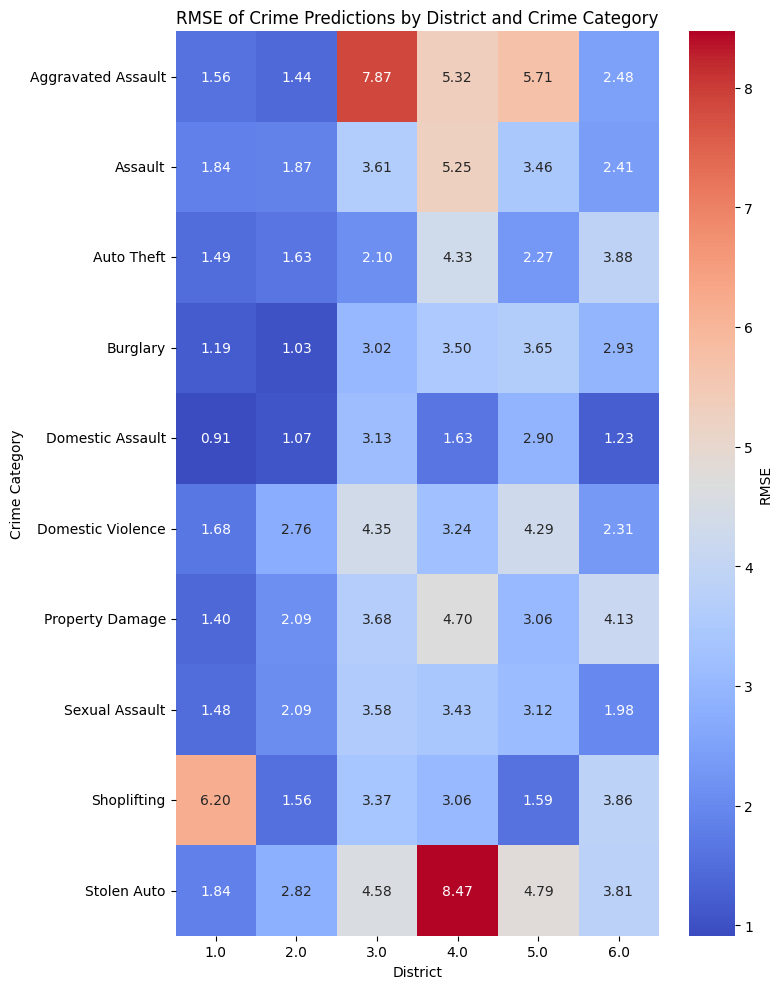

In [50]:
plot_rmse_heatmap(rmse_dict)